In [198]:
import matplotlib.pyplot as mp
import matplotlib

import pandas
import geopandas
import cartopy
import pygsheets
import numpy
import leafmap
import shapely
import pathlib
import textwrap

import gemplot

In [246]:
import importlib
import gemplot
importlib.reload(gemplot)
from gemplot import *

# import data

In [247]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1vE9J1kxLdm8uXySNbaGoTIhJFob-ho98uyGZvSYMRMA')

In [248]:
gas_plants_df = spreadsheet.worksheet('title', 'Gas plants - data').get_as_df()
lng_terminals_df = spreadsheet.worksheet('title', 'LNG terminals - data').get_as_df()
gas_pipelines_df = spreadsheet.worksheet('title', 'Gas pipelines - data').get_as_df()

gas_plants_df = gas_plants_df.replace('',numpy.nan)
lng_terminals_df = lng_terminals_df.replace('',numpy.nan)
gas_pipelines_df = gas_pipelines_df.replace('',numpy.nan)

In [249]:
countries = ['Vietnam',
             'Philippines',
             'Thailand',
             'Indonesia',
             'Malaysia']

## create geodataframe for terminals, gas plants, pipelines

In [250]:
lng_terminals_df['geometry'] = lng_terminals_df[['Longitude','Latitude']].apply(shapely.geometry.Point, axis=1)
lng_terminals_gdf = geopandas.GeoDataFrame(lng_terminals_df, geometry=lng_terminals_df.geometry)

In [251]:
gas_plants_df['geometry'] = gas_plants_df[['Longitude','Latitude']].apply(shapely.geometry.Point, axis=1)
gas_plants_gdf = geopandas.GeoDataFrame(gas_plants_df, geometry=gas_plants_df.geometry)

In [252]:
geojson_path = '/Users/baird/Dropbox/_git_ALL/_github-repos-gem/'+\
'GOIT-GGIT-pipeline-routes/data/individual-routes/gas-pipelines/'

geojson_route_files = list(
    pathlib.Path(
        geojson_path
    ).rglob('?????.geojson')
)

In [253]:
geojson_projectids = [str(i).split('/')[-1][:5] for i in geojson_route_files]

In [254]:
for idx,pid in enumerate(gas_pipelines_df.ProjectID.tolist()):
    try:
        file = geojson_path + pid + '.geojson'
        file_gdf = geopandas.read_file(file)
        file_geometry_dissolved = file_gdf.dissolve().geometry
        gas_pipelines_df.loc[gas_pipelines_df.ProjectID==pid,'geometry'] = file_geometry_dissolved[0]
    except:
        print(pid," geojson file either doesn't exist or has bad geometry")

In [255]:
gas_pipelines_gdf = geopandas.GeoDataFrame(gas_pipelines_df, geometry=gas_pipelines_df.geometry)

<Axes: >

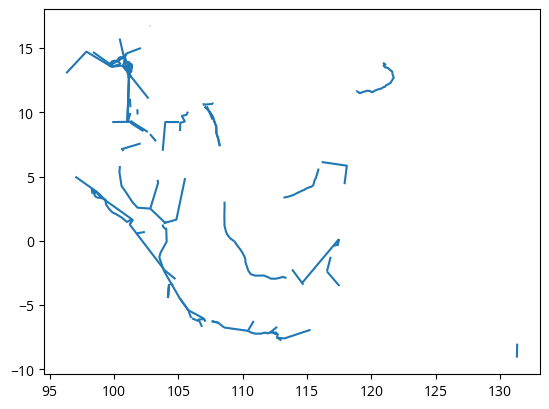

In [256]:
gas_pipelines_gdf.loc[(gas_pipelines_gdf.Status.isin(['Operating','Proposed','Construction']))&
                     (gas_pipelines_gdf.Countries.str.contains('|'.join(countries)))].geometry.plot()


# set font

In [257]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

# gemplot colors

In [258]:
ff_palette = ["#580000", "#902C00", "#BF532C", "#F98C28", "#FFD370"]
purple_palette = ["#392E66", "#4F408C", "#7468A4", "#9A91BD", "#BFBAD5"]

gp_op = purple_palette[0]
gp_con = purple_palette[1]
gp_precon = purple_palette[2]
gp_ann = purple_palette[3]

lng_op = ff_palette[1]
lng_con = ff_palette[2]
lng_prop = ff_palette[3]

# map color variables

In [259]:
#construction_color = matplotlib.colormaps['Reds'](0.75)

construction_color_terminals = ff_palette[0]
construction_color_gas_plants = ff_palette[1]
construction_color_pipelines = ff_palette[2]

proposed_color = matplotlib.colormaps['Oranges'](0.25)
#operating_color = '#c2c2c2'
other_land_color = '#ffffff'
other_land_alpha = 1
highlight_land_color = '#c2c2c2'
highlight_land_alpha = 0.4
water_color = '#a1bccc'
water_alpha = 0.3
operating_color = '0.25'
operating_terms_color = '0.666'
construction_lw = 2
construction_gas_lw = 1.5
operating_lw = 0.25
ehb_alpha = 1.

# import data
* natural earth states, provinces
* countries
* lakes and oceans

In [260]:
ne_states_provinces = '/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
ne_states_provinces_gdf = geopandas.read_file(ne_states_provinces)

In [261]:
countries_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_admin_0_countries_lakes/ne_50m_admin_0_countries_lakes.shp')

In [262]:
lakes_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_lakes/ne_10m_lakes.shp')
oceans_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_ocean/ne_10m_ocean.shp')

# figure 1 - map of everything

In [263]:
countries = ['Vietnam',
             'Philippines',
             'Thailand',
             'Indonesia',
             'Malaysia']

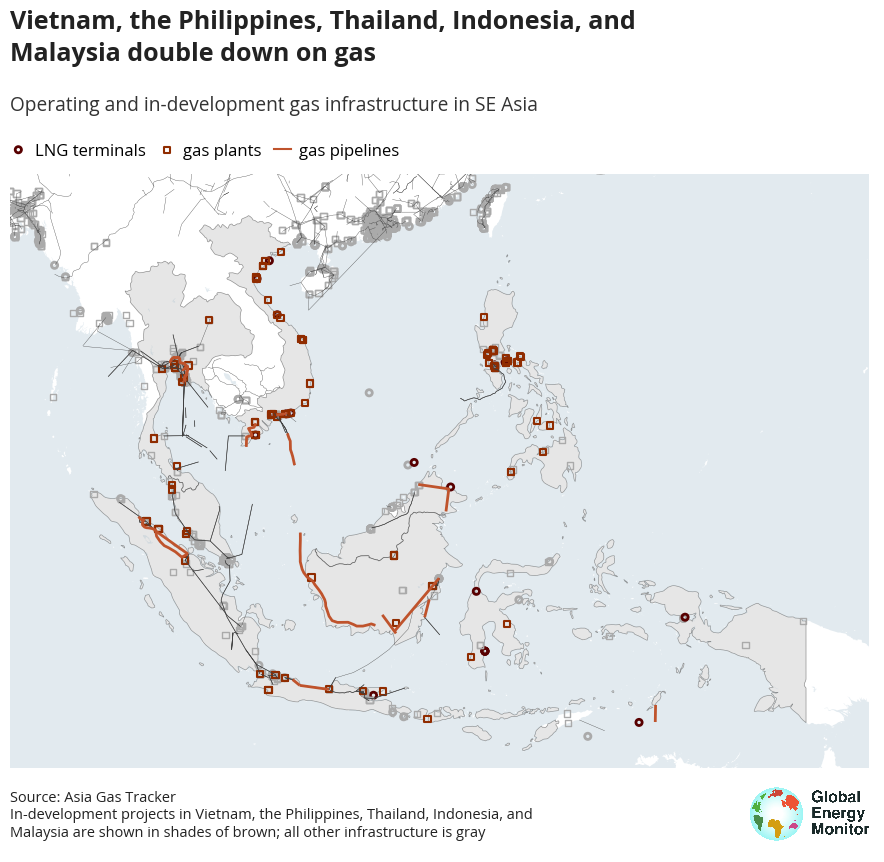

In [264]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,145,-12,26], crs=data_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(countries)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(countries)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)


# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(countries)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(countries)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=5)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(countries))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=20)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(countries))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=20)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(countries))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=3, marker='o',
           s=20, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(countries))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=20)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(countries))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=20)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(countries))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=4, marker='s',
           s=20, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.patches.Patch(color=construction_color_pipelines)
pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Operating and in-development gas infrastructure in SE Asia',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.045,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Vietnam, the Philippines, Thailand, Indonesia, and\nMalaysia double down on gas',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

# GEM LOGO AND NOTES
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.25), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Asia Gas Tracker\nIn-development projects in Vietnam, the Philippines, Thailand, Indonesia, and\nMalaysia are shown in shades of brown; all other infrastructure is gray',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.08*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

fig.savefig('../figures/figure1-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure1-map.pdf', 
            bbox_inches='tight',
            transparent=False)

# vietnam

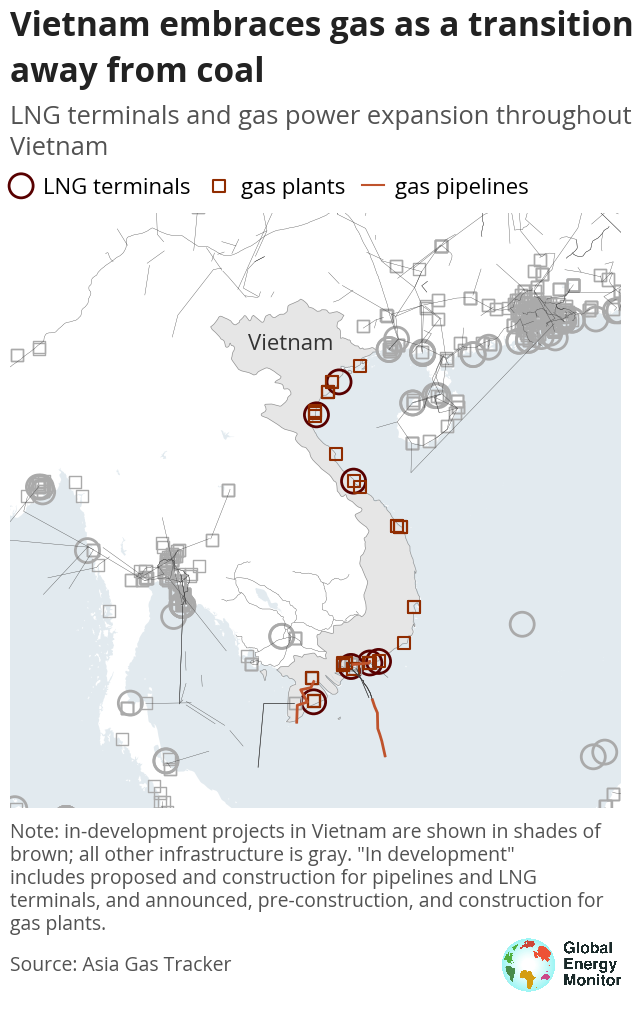

In [325]:
WHICH_COUNTRIES = ['Vietnam']

gp_size = 75
term_size = 300

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 500 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']

ax.set_extent([highlight_geometry.bounds.minx-7,
               highlight_geometry.bounds.maxx+7,
               highlight_geometry.bounds.miny-3,
               highlight_geometry.bounds.maxy+3], crs=data_proj)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)

# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=5)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=4, marker='s',
           s=gp_size, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('Vietnam embraces gas as a transition away from coal',38),
                       subtitle_text=textwrap.fill('LNG terminals and gas power expansion throughout Vietnam',50),
                       vertical_shift=0.025)

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: in-development projects in '+WHICH_COUNTRIES[0]+\
' are shown in shades of brown; all other infrastructure is gray. "In development" includes proposed and construction for pipelines and LNG terminals, \
and announced, pre-construction, and construction for gas plants.',65), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Asia Gas Tracker',
footer_position=2)

ax.text(s=WHICH_COUNTRIES[0],
        x=0.46,
        y=0.78,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle,
        alpha=1)

fig.savefig('../figures/figure2-vietnam-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure2-vietnam-map.pdf', 
            bbox_inches='tight',
            transparent=False)

# philippines

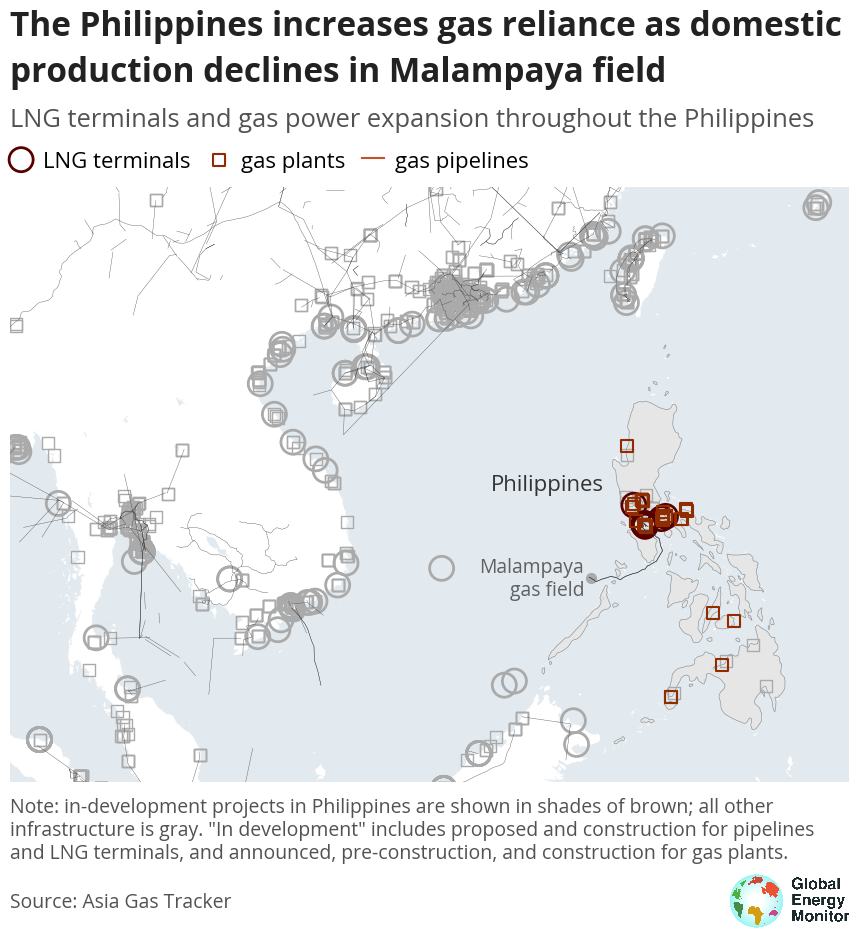

In [326]:
WHICH_COUNTRIES = ['Philippines']

gp_size = 75
term_size = 300

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']
ax.set_extent([highlight_geometry.bounds.minx-highlight_geometry.bounds.minx*.18,
               highlight_geometry.bounds.maxx+highlight_geometry.bounds.maxx*.02,
               highlight_geometry.bounds.miny-highlight_geometry.bounds.miny*.3,
               highlight_geometry.bounds.maxy+highlight_geometry.bounds.maxy*.3], crs=data_proj)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)


# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=5)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=4, marker='o',
           s=term_size, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=4, marker='s',
           s=gp_size, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('The Philippines increases gas reliance as domestic production declines in Malampaya field',55),
                       subtitle_text=textwrap.fill('LNG terminals and gas power expansion throughout the Philippines',70),
                       vertical_shift=0.03)

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: in-development projects in '+WHICH_COUNTRIES[0]+\
' are shown in shades of brown; all other infrastructure is gray. "In development" includes proposed and construction for pipelines and LNG terminals, \
and announced, pre-construction, and construction for gas plants.',90), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Asia Gas Tracker',
footer_position=1.6)

ax.text(s=WHICH_COUNTRIES[0],
        x=0.64,
        y=0.5,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle,
        alpha=1)

### ADD MALAMPAYA
malampaya_xy = [118.9,11.6]
ax.scatter(x=malampaya_xy[0],
           y=malampaya_xy[1],
           transform=data_proj,
           facecolor=operating_terms_color, 
           # edgecolor=operating_terms_color, 
           # linewidth=1,
           zorder=3, marker='o',
           s=50)
ax.text(s='Malampaya\ngas field',
        x=malampaya_xy[0]-0.25,
        y=malampaya_xy[1],
        transform=data_proj,
        size=font_size_axis*0.875,
        color=color_subtitle,
        ha='right',
        va='center',
        weight=text_weight_normal,
        # linespacing=1.2,
        wrap=False, alpha=0.75)

fig.savefig('../figures/figure3-philippines-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure3-philippines-map.pdf', 
            bbox_inches='tight',
            transparent=False)

# thailand

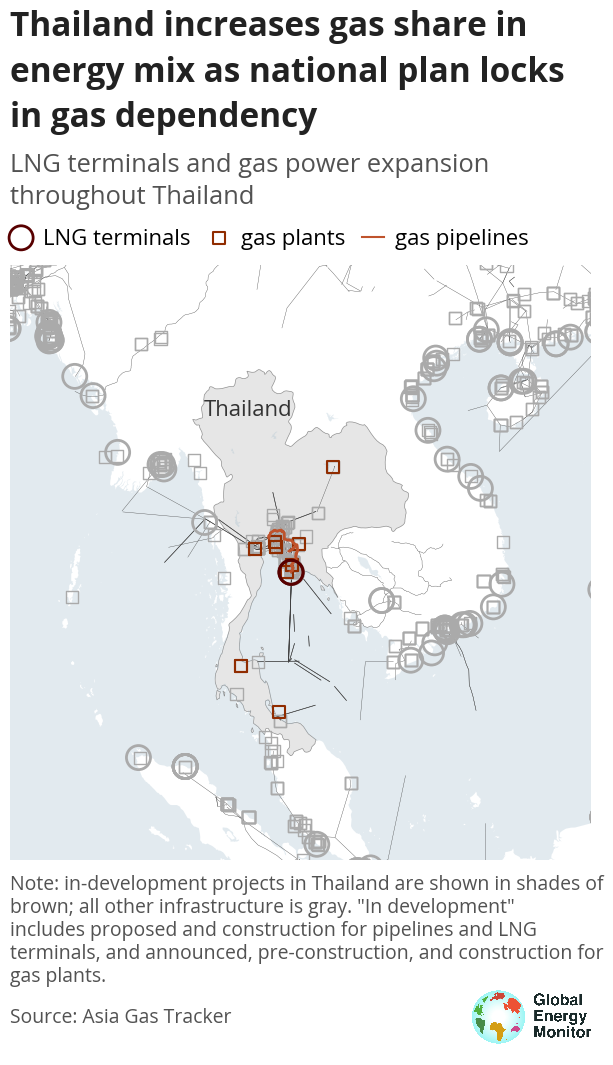

In [317]:
WHICH_COUNTRIES = ['Thailand']

gp_size = 75
term_size = 300

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']
ax.set_extent([highlight_geometry.bounds.minx-7,
               highlight_geometry.bounds.maxx+7,
               highlight_geometry.bounds.miny-4,
               highlight_geometry.bounds.maxy+4], crs=data_proj)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)


# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=3)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=3)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=5)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=5, marker='o',
           s=term_size, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=4, marker='s',
           s=gp_size, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('Thailand increases gas share in energy mix as national plan locks in gas dependency',35),
                       subtitle_text=textwrap.fill('LNG terminals and gas power expansion throughout Thailand',45),
                       vertical_shift=0.03)

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: in-development projects in '+WHICH_COUNTRIES[0]+\
' are shown in shades of brown; all other infrastructure is gray. "In development" includes proposed and construction for pipelines and LNG terminals, \
and announced, pre-construction, and construction for gas plants.',65), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Asia Gas Tracker',
footer_position=2)

ax.text(s=WHICH_COUNTRIES[0],
        x=0.41,
        y=0.755,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle,
        alpha=1)

fig.savefig('../figures/figure4-thailand-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure4-thailand-map.pdf', 
            bbox_inches='tight',
            transparent=False)

# indonesia

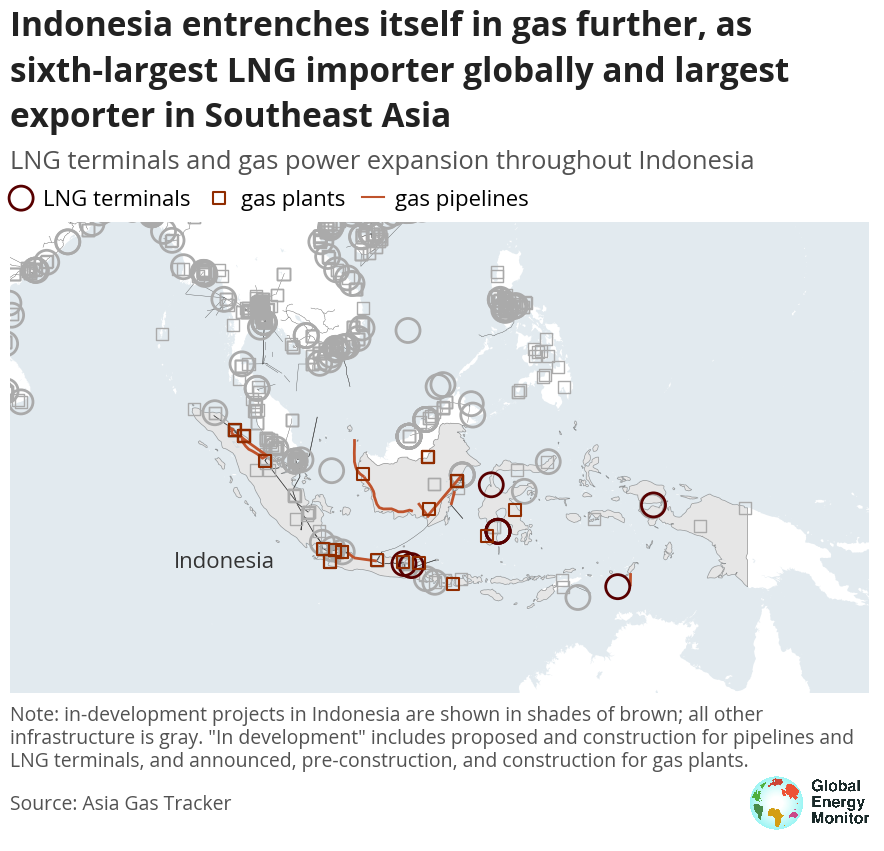

In [308]:
WHICH_COUNTRIES = ['Indonesia']

gp_size = 75
term_size = 300

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']
ax.set_extent([highlight_geometry.bounds.minx-15,
               highlight_geometry.bounds.maxx+10,
               highlight_geometry.bounds.miny-7,
               highlight_geometry.bounds.maxy+15], crs=data_proj)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)


# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=3)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=3)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=4)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=3, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=4, marker='o',
           s=term_size, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=5, marker='s',
           s=gp_size, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('Indonesia entrenches itself in gas further, as \
sixth-largest LNG importer globally and largest exporter in Southeast Asia',51),
                       subtitle_text=textwrap.fill('LNG terminals and gas power expansion throughout Indonesia',70),
                       vertical_shift=0.03)

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: in-development projects in '+WHICH_COUNTRIES[0]+\
' are shown in shades of brown; all other infrastructure is gray. "In development" includes proposed and construction for pipelines and LNG terminals, \
and announced, pre-construction, and construction for gas plants.',95), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Asia Gas Tracker',
footer_position=1.5)

ax.text(s=WHICH_COUNTRIES[0],
        x=0.25,
        y=0.28,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle,
        alpha=1)

fig.savefig('../figures/figure5-indonesia-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure5-indonesia-map.pdf', 
            bbox_inches='tight',
            transparent=False)

# malaysia

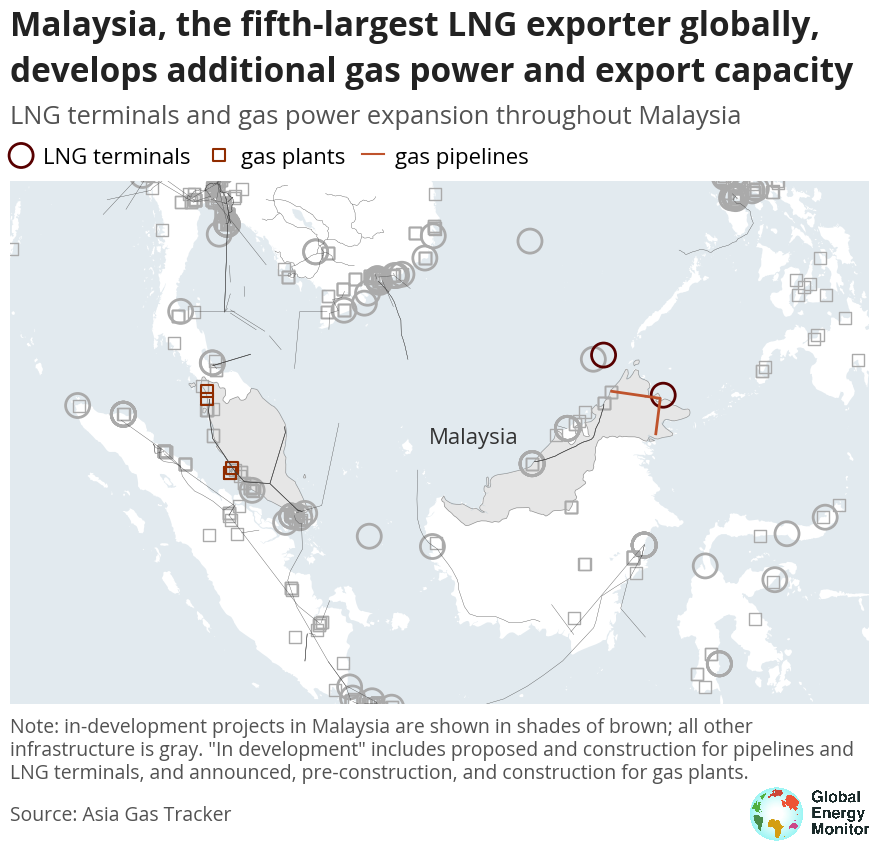

In [306]:
WHICH_COUNTRIES = ['Malaysia']

gp_size = 75
term_size = 300

map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=other_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=other_land_alpha)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']
ax.set_extent([highlight_geometry.bounds.minx-7,
               highlight_geometry.bounds.maxx+7,
               highlight_geometry.bounds.miny-7,
               highlight_geometry.bounds.maxy+7], crs=data_proj)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)


# PIPELINES
ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction','Operating','Shelved']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color,
                  linewidth=operating_lw, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Operating']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=operating_color, 
                  linewidth=operating_lw*2, zorder=5)

ax.add_geometries(gas_pipelines_gdf.loc[
                  (gas_pipelines_gdf.Status.isin(['Proposed', 'Construction']))&
                  (gas_pipelines_gdf.Countries.str.contains('|'.join(WHICH_COUNTRIES)))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=construction_color_pipelines,
                  linewidth=construction_lw, zorder=5)

# TERMINALS
points_list = lng_terminals_gdf.loc[(~lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))&
                                    (~lng_terminals_gdf.geometry.is_empty)].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=4, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Operating']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=2,
           zorder=4, marker='o',
           s=term_size)

points_list = lng_terminals_gdf.loc[(lng_terminals_gdf.Status.isin(['Proposed','Construction']))&
                            (lng_terminals_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_terminals, 
           linewidth=2,
           zorder=4, marker='o',
           s=term_size, label='LNG terminals')


# GAS PLANTS
points_list = gas_plants_gdf.loc[
                            (~gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['operating']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=operating_terms_color, 
           linewidth=1,
           zorder=3, marker='s',
           s=gp_size)

points_list = gas_plants_gdf.loc[(gas_plants_gdf.Status.isin(['announced','pre-construction','construction']))&
                            (gas_plants_gdf.Country.isin(WHICH_COUNTRIES))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=construction_color_gas_plants, 
           linewidth=construction_gas_lw,
           zorder=4, marker='s',
           s=gp_size, label='gas plants')

fig.tight_layout()

# turn off outline
#ax.outline_patch.set_visible(False)
ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=construction_color_pipelines)
pipeline_indev_label = 'gas pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('Malaysia, the fifth-largest LNG exporter globally, develops additional gas power and export capacity',55),
                       subtitle_text=textwrap.fill('LNG terminals and gas power expansion throughout Malaysia',70),
                       vertical_shift=0.03)
                       

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: in-development projects in '+WHICH_COUNTRIES[0]+\
' are shown in shades of brown; all other infrastructure is gray. "In development" includes proposed and construction for pipelines and LNG terminals, \
and announced, pre-construction, and construction for gas plants.',95), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Asia Gas Tracker',
footer_position=1.5)


ax.text(s=WHICH_COUNTRIES[0],
        x=0.54,
        y=0.51,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle,
        alpha=1)

fig.savefig('../figures/figure6-malaysia-map.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('../figures/figure6-malaysia-map.pdf', 
            bbox_inches='tight',
            transparent=False)